In [2]:
import gzip
import json

import time
from datetime import datetime

import pandas as pd
import numpy as np

import sklearn as skl

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import umap
from sklearn.manifold import TSNE

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering

warnings.filterwarnings("ignore")
%matplotlib inline

# EDA

In [3]:
#получение данных из источника, отбор по unixReviewTime

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

data_meta = getDF('/home/dataengineer/OTUS_ML/rs_data/meta_Digital_Music.json.gz')
data_review_all = getDF('/home/dataengineer/OTUS_ML/rs_data/Digital_Music.json.gz')

data_review_all = data_review_all[data_review_all['unixReviewTime'] >= 1483228800]

In [4]:
#предварителная обработка справочника

data_meta.loc[data_meta.brand.str.len() < 3, 'brand'] = 'unknown'
data_meta['item_name'] = data_meta['brand'] + ' - ' + data_meta['title']
data_meta = data_meta.drop(['category','tech1', 'description', 'fit', 'also_buy', 'image', 'tech2', 'feature', 
                            'rank', 'also_view', 'main_cat', 'similar_item', 'date', 'details', 'price', 'title'], axis=1)
data_meta.info()
data_meta.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74347 entries, 0 to 74346
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   brand      74347 non-null  object
 1   asin       74347 non-null  object
 2   item_name  74347 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB


,brand,asin,item_name
0,John Michael Talbot,0001377647,John Michael Talbot - Master Collection Volume...
1,Second Chapter of Acts,0001529145,Second Chapter of Acts - Hymns Collection: Hym...
2,Don Francisco,0001527134,Don Francisco - Early Works - Don Francisco
3,Keith Green,0001388703,Keith Green - So You Wanna Go Back to Egypt
4,Dallas Holm,0001526146,Dallas Holm - Early Works - Dallas Holm


In [5]:
#оценка количества отзывов по товарам

data_i = data_review_all.groupby('asin').agg(reviews_total = pd.NamedAgg(column = 'overall', aggfunc = 'count'))
data_i_r = data_i.groupby('reviews_total').agg(reviews_total_count = pd.NamedAgg(column = 'reviews_total', aggfunc = 'count'))   
data_i_r

,reviews_total_count
reviews_total,
1,73224
2,11135
3,3876
4,2047
5,1189
...,...
400,1
533,1
768,1


In [6]:
#оценка количества отзывов по пользователям

data_u = data_review_all.groupby('reviewerID').agg(reviews_total = pd.NamedAgg(column = 'overall', aggfunc = 'count'))
data_u_r = data_u.groupby('reviews_total').agg(reviews_total_count = pd.NamedAgg(column = 'reviews_total', aggfunc = 'count'))   
data_u_r

,reviews_total_count
reviews_total,
1,89708
2,12447
3,4109
4,1844
5,1061
...,...
118,1
121,1
143,1


In [7]:
#отбор данных по пользователям и товарам, имеющим достаточно отзывов

filter_items = data_review_all['asin'].value_counts() >= 2
filter_items = filter_items[filter_items].index.tolist()

filter_users = data_review_all['reviewerID'].value_counts() >= 2
filter_users = filter_users[filter_users].index.tolist()

data_review = data_review_all[(data_review_all['asin'].isin(filter_items)) & (data_review_all['reviewerID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(data_review_all.shape))
print('The new data frame shape:\t{}'.format(data_review.shape))

The original data frame shape:	(175051, 12)
The new data frame shape:	(47022, 12)


In [8]:
#предварительная обработка фактов

def flag_by_range(value, min_value, max_value):    
    if min_value <= value <= max_value:
        flag = 1      
    else:
        flag = 0        
    return flag


data_review['vote'] = pd.to_numeric(data_review['vote'].str.replace(',', '.', regex=True)).fillna(0)

data_review['overall'] = data_review['overall'].astype(int)

data_review['r'] = data_review['overall']
data_review = pd.get_dummies(data_review, columns=['r'])

data_review['rewiev_len'] = data_review['reviewText'].str.split().str.len().fillna(0).astype(int)
data_review['short_rewiev'] = data_review.apply(lambda row: flag_by_range(row.rewiev_len, 0, 5), axis = 1)
data_review['middle_rewiev'] = data_review.apply(lambda row: flag_by_range(row.rewiev_len, 6, 20), axis = 1)
data_review['long_rewiev'] = data_review.apply(lambda row: flag_by_range(row.rewiev_len, 21, 1000000), axis = 1)

data_review = data_review.drop(['verified', 'reviewTime', 'style', 'reviewerName', 'summary', 'image', 'reviewText'], axis=1)

data_review.info()
data_review.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47022 entries, 249 to 1584081
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         47022 non-null  int64  
 1   reviewerID      47022 non-null  object 
 2   asin            47022 non-null  object 
 3   unixReviewTime  47022 non-null  int64  
 4   vote            47022 non-null  float64
 5   r_1             47022 non-null  uint8  
 6   r_2             47022 non-null  uint8  
 7   r_3             47022 non-null  uint8  
 8   r_4             47022 non-null  uint8  
 9   r_5             47022 non-null  uint8  
 10  rewiev_len      47022 non-null  int64  
 11  short_rewiev    47022 non-null  int64  
 12  middle_rewiev   47022 non-null  int64  
 13  long_rewiev     47022 non-null  int64  
dtypes: float64(1), int64(6), object(2), uint8(5)
memory usage: 3.8+ MB


,overall,reviewerID,asin,unixReviewTime,vote,r_1,r_2,r_3,r_4,r_5,rewiev_len,short_rewiev,middle_rewiev,long_rewiev
249,5,A2REF5NAGDO02L,1932192077,1509321600,4.0,0,0,0,0,1,34,0,0,1
257,4,A13HYXXFXJKQ0P,1932192077,1502582400,3.0,0,0,0,1,0,30,0,0,1
484,5,APPEUNQO889AZ,5557585400,1483315200,0.0,0,0,0,0,1,2,1,0,0
696,5,ADBL70MV2FRCY,5557706259,1484265600,0.0,0,0,0,0,1,5,1,0,0
994,5,A1XL1WKRIGSTGE,5559166928,1512604800,0.0,0,0,0,0,1,5,1,0,0


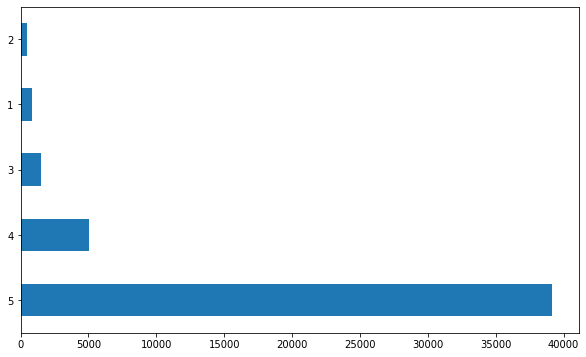

In [9]:
#оценка распределения рейтингов

r_plot = data_review['overall'].value_counts()
r_plot.plot(kind='barh', figsize=(10, 6))
plt.show()  

# Clustering

## Preprocessing & Feature Engineering

In [10]:
#подготовка данных о пользователях для кластеризации

data_users = data_review.groupby('reviewerID').agg(
    reviews_total = pd.NamedAgg(column = 'overall', aggfunc = 'count'),
    r_1_total = pd.NamedAgg(column = 'r_1', aggfunc = 'sum'),
    r_2_total = pd.NamedAgg(column = 'r_2', aggfunc = 'sum'),
    r_3_total = pd.NamedAgg(column = 'r_3', aggfunc = 'sum'),
    r_4_total = pd.NamedAgg(column = 'r_4', aggfunc = 'sum'),
    r_5_total = pd.NamedAgg(column = 'r_5', aggfunc = 'sum'),
    votes_total = pd.NamedAgg(column = 'vote', aggfunc = 'sum'),
    short_review_total = pd.NamedAgg(column = 'short_rewiev', aggfunc = 'sum'),
    middle_review_total = pd.NamedAgg(column = 'middle_rewiev', aggfunc = 'sum'),
    long_review_total = pd.NamedAgg(column = 'long_rewiev', aggfunc = 'sum'),
    time_first_review = pd.NamedAgg(column = 'unixReviewTime', aggfunc = 'min'),
    time_last_review = pd.NamedAgg(column = 'unixReviewTime', aggfunc = 'max'),
    )

data_users['user_lt_days'] = (data_users['time_last_review'] - data_users['time_first_review']) / 86400 + 1
#data_users['has_history'] = data_users.apply(lambda row: 1 if row.user_lt_days > 1 else 0, axis = 1)

data_users = data_users.drop(['time_first_review', 'time_last_review'], axis=1)

data_users.reset_index(inplace=True)

data_users

,reviewerID,reviews_total,r_1_total,r_2_total,r_3_total,r_4_total,r_5_total,votes_total,short_review_total,middle_review_total,long_review_total,user_lt_days
0,A01017092Y47IR6CS8FJ,1,0,0,0,0,1,0.0,0,0,1,1.0
1,A0108129TLIKAX34M8AA,3,0,0,0,0,3,0.0,3,0,0,8.0
2,A01241534EPLP5O3KOP5,2,0,0,0,0,2,0.0,0,2,0,1.0
3,A0266076X6KPZ6CCHGVS,2,0,0,0,0,2,0.0,2,0,0,1.0
4,A06818207QDXOKXENCIB,2,0,0,0,0,2,0.0,0,2,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17482,AZYPLRW0MEGW5,2,0,0,0,0,2,0.0,0,0,2,1.0
17483,AZYUZ5YDQYKG3,1,0,0,0,0,1,0.0,0,1,0,1.0
17484,AZYVCAJ8O71NK,2,0,0,0,0,2,0.0,0,2,0,1.0
17485,AZZAC4HXYMS6F,1,0,0,0,0,1,0.0,0,0,1,1.0


In [11]:
#стандартизация

data_users_sc = StandardScaler().fit_transform(data_users[['reviews_total', 'r_1_total', 'r_2_total', 'r_3_total', 'r_4_total',
                                                           'r_5_total', 'votes_total','user_lt_days', 
                                                           'short_review_total', 'middle_review_total', 'long_review_total']])

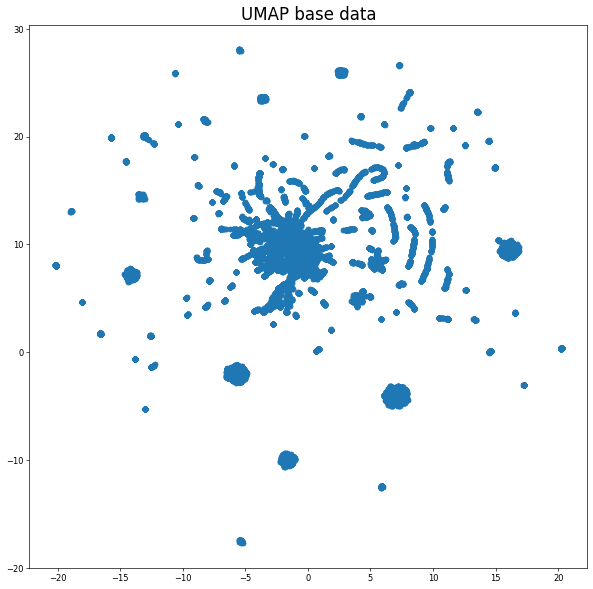

In [12]:
#визуализация исходных данных в сжатом признаковом пространстве UMAP

data_users_umap = umap.UMAP(random_state=42).fit_transform(data_users_sc)

plt.figure(figsize=(12, 12), dpi= 60)
plt.title("UMAP base data", fontsize=20)
plt.scatter(data_users_umap[:, 0], data_users_umap[:, 1])

## Modelling

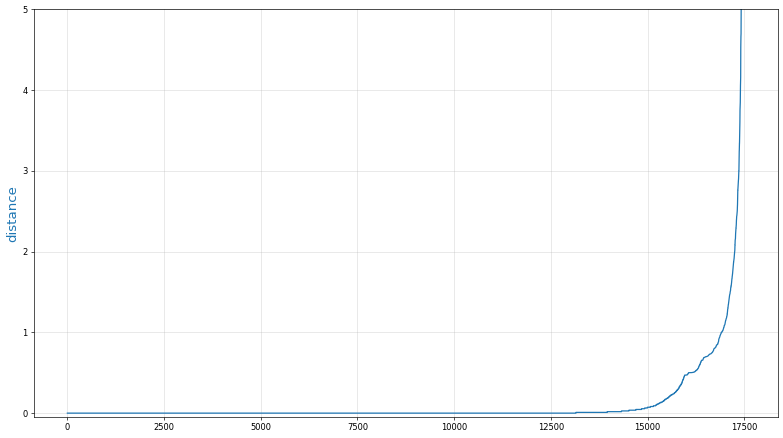

In [13]:
#нахождение оптимального значения eps с помощью NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data_users_sc)
distances, indices = nbrs.kneighbors(data_users_sc)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

fig, ax = plt.subplots(1,1,figsize=(16,9), dpi= 60)
ax.set_ylabel('distance', color='tab:blue', fontsize=16)
ax.grid(alpha=.4)
ax.set_ylim(ymin=-0.05, ymax=5)
plt.plot(distances)


In [14]:
#построение модели DBSCAN

db = DBSCAN(eps=0.1, min_samples=500)
db.fit(data_users_sc)

data_users_labels = db.labels_

n_clusters = len(set(data_users_labels)) - (1 if -1 in data_users_labels else 0)
print("Clusters total: " + str(n_clusters))

Clusters total: 6


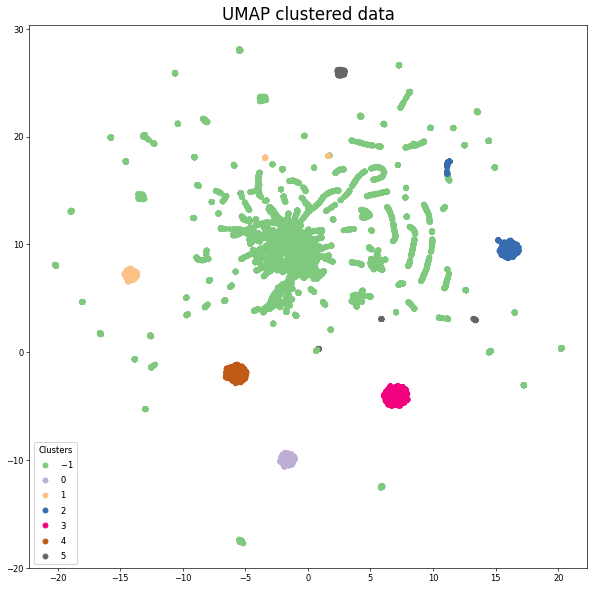

In [15]:
#визуализация результатов кластеризации в сжатом признаковом пространстве UMAP

fig, ax = plt.subplots(figsize=(12, 12), dpi= 60)

plt.title("UMAP clustered data", fontsize=20)
scatter = ax.scatter(data_users_umap[:, 0], data_users_umap[:, 1], c = data_users_labels, cmap="Accent")
legend = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Clusters")
ax.add_artist(legend)

In [16]:
#добавление ID кластера к данным о пользователях

data_users['clusterID'] = data_users_labels
data_users

,reviewerID,reviews_total,r_1_total,r_2_total,r_3_total,r_4_total,r_5_total,votes_total,short_review_total,middle_review_total,long_review_total,user_lt_days,clusterID
0,A01017092Y47IR6CS8FJ,1,0,0,0,0,1,0.0,0,0,1,1.0,0
1,A0108129TLIKAX34M8AA,3,0,0,0,0,3,0.0,3,0,0,8.0,-1
2,A01241534EPLP5O3KOP5,2,0,0,0,0,2,0.0,0,2,0,1.0,1
3,A0266076X6KPZ6CCHGVS,2,0,0,0,0,2,0.0,2,0,0,1.0,2
4,A06818207QDXOKXENCIB,2,0,0,0,0,2,0.0,0,2,0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17482,AZYPLRW0MEGW5,2,0,0,0,0,2,0.0,0,0,2,1.0,-1
17483,AZYUZ5YDQYKG3,1,0,0,0,0,1,0.0,0,1,0,1.0,4
17484,AZYVCAJ8O71NK,2,0,0,0,0,2,0.0,0,2,0,1.0,1
17485,AZZAC4HXYMS6F,1,0,0,0,0,1,0.0,0,0,1,1.0,0


In [17]:
#оценка распределения пользователей по кластерам

data_users_clusters = data_users.groupby('clusterID').agg(
    users_total = pd.NamedAgg(column = 'reviewerID', aggfunc = 'count'),
    reviews_mean = pd.NamedAgg(column = 'reviews_total', aggfunc = 'mean'),
    r_1_mean = pd.NamedAgg(column = 'r_1_total', aggfunc = 'mean'),
    r_2_mean = pd.NamedAgg(column = 'r_2_total', aggfunc = 'mean'),
    r_3_mean = pd.NamedAgg(column = 'r_3_total', aggfunc = 'mean'),
    r_4_mean = pd.NamedAgg(column = 'r_4_total', aggfunc = 'mean'),
    r_5_mean = pd.NamedAgg(column = 'r_5_total', aggfunc = 'mean'),
    votes_mean = pd.NamedAgg(column = 'votes_total', aggfunc = 'mean'),
    short_rewiev_mean = pd.NamedAgg(column = 'short_review_total', aggfunc = 'mean'),
    middle_rewiev_mean = pd.NamedAgg(column = 'middle_review_total', aggfunc = 'mean'),
    long_rewiev_mean = pd.NamedAgg(column = 'long_review_total', aggfunc = 'mean'),
    user_lt_days_mean = pd.NamedAgg(column = 'user_lt_days', aggfunc = 'mean'),
    )

data_users_clusters.sort_values(by=['users_total'], ascending=False)

,users_total,reviews_mean,r_1_mean,r_2_mean,r_3_mean,r_4_mean,r_5_mean,votes_mean,short_rewiev_mean,middle_rewiev_mean,long_rewiev_mean,user_lt_days_mean
clusterID,,,,,,,,,,,,
-1,9779,3.711525,0.08958,0.045812,0.155742,0.514572,2.905819,0.452091,1.890684,1.070048,0.750793,93.615400
3,1999,1.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
4,1692,1.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
2,1616,2.000000,0.00000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000,1.605198
0,998,1.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
1,881,2.000000,0.00000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.000000,1.607264
5,522,2.000000,0.00000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,1.000000,0.000000,2.308429


# Рекомендательные системы

## Preprocessing & Feature Engineering

In [18]:
#получение набора данных для рекомендательных систем с clusterID

data_rs = pd.merge(data_review[['reviewerID', 'asin', 'overall']], data_users[['reviewerID', 'clusterID']], on='reviewerID', how='outer')

data_rs

,reviewerID,asin,overall,clusterID
0,A2REF5NAGDO02L,1932192077,5,-1
1,A2REF5NAGDO02L,B01BIR6FTS,5,-1
2,A13HYXXFXJKQ0P,1932192077,4,-1
3,A13HYXXFXJKQ0P,B00ANGT0PM,5,-1
4,APPEUNQO889AZ,5557585400,5,3
...,...,...,...,...
47017,AO98439TZNUDN,B01HIY8QVU,1,-1
47018,AHBZ9QJ0FL607,B01HJ91O5O,5,0
47019,A3O8BGD267TZHT,B01HJ91MTW,5,0
47020,A3V2V7PUFZUM2T,B01HJ91P94,5,4


## Modelling

### Кросс-валидация и выбор алгоритма для каждого кластера

In [21]:
#функция для кросс-валидации и выбора алгоритма для каждого кластера

def rs_cv_by_clusters (rating_scale, clusters, columns):
    
    surprise_results_union = pd.DataFrame(columns = ['Algorithm', 'test_rmse', 'fit_time', 'test_time'])
    surprise_results_union.index.name = 'Cluster'
    
    for cluster in clusters:
        reader = Reader(rating_scale=rating_scale)
        data = Dataset.load_from_df(data_rs[data_rs['clusterID'] == cluster][columns], reader)

        benchmark = []

        for algorithm in [SVD(), KNNWithMeans()]:

            results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
            tmp = pd.DataFrame.from_dict(results).mean(axis=0)
            tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
            tmp = tmp.append(pd.Series([cluster], index=['Cluster']))
            benchmark.append(tmp)
    
            surprise_results = pd.DataFrame(benchmark).set_index('Cluster') 
            surprise_results = surprise_results[['Algorithm', 'test_rmse', 'fit_time', 'test_time']]
            
        surprise_results_union = pd.concat([surprise_results_union, surprise_results])

    return surprise_results_union

In [22]:
#кросс-валидация и выбор алгоритма для каждого кластеров

clusters_arr = data_rs.clusterID.sort_values().unique()
r_scale = (1, 5)
cols = ['reviewerID', 'asin', 'overall']

surprise_result_by_clusters = rs_cv_by_clusters(r_scale, clusters_arr, cols)
surprise_result_by_clusters

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

,Algorithm,test_rmse,fit_time,test_time
Cluster,,,,
-1,SVD,0.760015,1.079147,0.074321
-1,KNNWithMeans,0.791405,1.734221,0.155169
0,SVD,0.001229,0.028816,0.001382
0,KNNWithMeans,0.000000,0.009402,0.001689
1,SVD,0.026382,0.047776,0.003207
1,KNNWithMeans,0.000000,0.012933,0.004634
2,SVD,0.033171,0.089298,0.005798
2,KNNWithMeans,0.000000,0.032591,0.008563
3,SVD,0.002043,0.057980,0.002889


In [23]:
#кросс-валидация и выбор алгоритма для всего массива данных без учета кластеров

def rs_cv (rating_scale, columns):
    
    reader = Reader(rating_scale=rating_scale)
    data = Dataset.load_from_df(data_rs[columns], reader)

    benchmark = []

    for algorithm in [SVD(), KNNWithMeans()]:

        results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
        tmp = pd.DataFrame.from_dict(results).mean(axis=0)
        tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
        benchmark.append(tmp)
    
        surprise_result = pd.DataFrame(benchmark).set_index('Algorithm')
        
    return surprise_result


surprise_result_no_clusters = rs_cv(r_scale, cols)  

surprise_result_no_clusters

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.683549,1.378499,0.089270
KNNWithMeans,0.695428,4.793865,0.169384


###  Проверка предсказаний рейтингов для отдельных кластеров и набора данных в целом

In [25]:
#проверка предсказаний для кластера 3

с3_reader = Reader(rating_scale=r_scale)
с3_data = Dataset.load_from_df(data_rs[data_rs['clusterID'] == 3][cols], с3_reader) 

с3_trainset, с3_testset = train_test_split(с3_data, test_size=0.25)
с3_algo = KNNWithMeans()
с3_predictions = с3_algo.fit(с3_trainset).test(с3_testset)
accuracy.rmse(с3_predictions)

с3_rs_results = pd.DataFrame(с3_predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
с3_rs_results['err'] = abs(с3_rs_results.est - с3_rs_results.rui)
с3_rs_results = с3_rs_results[['uid', 'iid', 'rui', 'est', 'err', 'details']]

с3_rs_results

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.0000


,uid,iid,rui,est,err,details
0,APVKLPDKEO309,B003ULZZN8,5.0,5,0.0,"{'was_impossible': True, 'reason': 'User and/o..."
1,A2AX55JI4USYNN,B01AZG6EZI,5.0,5,0.0,"{'was_impossible': True, 'reason': 'User and/o..."
2,AD1VXYZ3CQ37,B004YBC8OM,5.0,5,0.0,"{'was_impossible': True, 'reason': 'User and/o..."
3,A34S1NSJ3GNIZD,B000W08GMW,5.0,5,0.0,"{'was_impossible': True, 'reason': 'User and/o..."
4,AAWG24WCY6BN7,B000TDYITM,5.0,5,0.0,"{'was_impossible': True, 'reason': 'User and/o..."
...,...,...,...,...,...,...
495,A13MH6HGBRS3XT,B00XNH1VC8,5.0,5,0.0,"{'was_impossible': True, 'reason': 'User and/o..."
496,A1DAXWCAF4ORKV,B01AZGC0HO,5.0,5,0.0,"{'was_impossible': True, 'reason': 'User and/o..."
497,AAXBBYRTOB73F,B001UYOOOI,5.0,5,0.0,"{'was_impossible': True, 'reason': 'User and/o..."
498,A1Y2KB4VYAZE7G,B0015RA8UY,5.0,5,0.0,"{'was_impossible': True, 'reason': 'User and/o..."


In [26]:
#проверка предсказаний для кластера -1

сn_reader = Reader(rating_scale=r_scale)
сn_data = Dataset.load_from_df(data_rs[data_rs['clusterID'] == -1][cols], сn_reader) 

сn_trainset, сn_testset = train_test_split(сn_data, test_size=0.25)
сn_algo = SVD()
сn_predictions = сn_algo.fit(сn_trainset).test(сn_testset)
accuracy.rmse(сn_predictions)

сn_rs_results = pd.DataFrame(сn_predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
сn_rs_results['err'] = abs(сn_rs_results.est - сn_rs_results.rui)
сn_rs_results = сn_rs_results[['uid', 'iid', 'rui', 'est', 'err', 'details']]

сn_rs_results

RMSE: 0.7484


,uid,iid,rui,est,err,details
0,A3CMSC7HZMYCC2,B00TLARXJ6,5.0,4.716143,0.283857,{'was_impossible': False}
1,A2JVV3KO5KXFLG,B000R4F9Z0,5.0,4.679376,0.320624,{'was_impossible': False}
2,ARWGLG0D7FC2V,B0009MW6DI,5.0,4.592174,0.407826,{'was_impossible': False}
3,A2M8D312G6B8ND,B000VRLAJ2,5.0,4.820336,0.179664,{'was_impossible': False}
4,A1GOGJODC03BFK,B01CTNN0PW,5.0,4.675952,0.324048,{'was_impossible': False}
...,...,...,...,...,...,...
9069,A1JRENLHPHUGD8,B00FK6RCGY,5.0,4.722981,0.277019,{'was_impossible': False}
9070,A37BELKOZGBRM5,B01BO914PK,5.0,4.538307,0.461693,{'was_impossible': False}
9071,AX2IQHG1JRM7Y,B003YNJU56,5.0,4.713433,0.286567,{'was_impossible': False}
9072,A2HSLEK73KXFEJ,B00G6OMIHC,5.0,4.746499,0.253501,{'was_impossible': False}


In [27]:
#проверка предсказаний для всего набора данных без учета кластеров

full_reader = Reader(rating_scale=r_scale)
full_data = Dataset.load_from_df(data_rs[cols], full_reader) 

full_trainset, full_testset = train_test_split(full_data, test_size=0.25)
full_algo = SVD()
full_predictions = full_algo.fit(full_trainset).test(full_testset)
accuracy.rmse(full_predictions)

full_rs_results = pd.DataFrame(full_predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
full_rs_results['err'] = abs(full_rs_results.est - full_rs_results.rui)
full_rs_results = full_rs_results[['uid', 'iid', 'rui', 'est', 'err', 'details']]

full_rs_results

RMSE: 0.6801


,uid,iid,rui,est,err,details
0,A1X5ND1XCYWNOA,B00136S3U4,4.0,4.724777,0.724777,{'was_impossible': False}
1,A2R7ZONPUVJZBR,B002DD9KIU,3.0,4.404545,1.404545,{'was_impossible': False}
2,A11XP2VUZZ0BEN,B000PU54J2,5.0,4.590328,0.409672,{'was_impossible': False}
3,A1ADHCTT83EW06,B001IBE3IK,5.0,4.828928,0.171072,{'was_impossible': False}
4,A2HVVO0WRB3EPJ,B00RR9SLMQ,5.0,4.820256,0.179744,{'was_impossible': False}
...,...,...,...,...,...,...
11751,A2JQ3J2JNH3JWE,B0013D8CDK,5.0,4.745658,0.254342,{'was_impossible': False}
11752,A33A7PHDZ7WZCA,B0040I3AQE,5.0,4.729500,0.270500,{'was_impossible': False}
11753,A27DZKB17XMMB4,B000U8O5QC,5.0,4.666289,0.333711,{'was_impossible': False}
11754,A1DTVSH7LBLDCU,B001BHVUUK,5.0,4.721309,0.278691,{'was_impossible': False}
